In [7]:
# This code compute preliminary statistical analyses on RS CLOSED DATA
# 1) Descriptive statistics
# 2) Linear mixed model on every region with group and resting state block as fixed effects, and subject ID as random effect
# 3) Clustering of ASD subject based on general IQ
# 2) Linear mixed model on every region with IQ-based subgroups and resting state block as fixed effects, and subject ID as random effect


# Import libraries and set directories

import os
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# environment name: explore_cmifoof

# Set paths
main = '/Users/inesseverino/Library/CloudStorage/OneDrive-FondazioneIstitutoItalianoTecnologia/PythonCourse/python-cimec-ines-severino/'



data = pd.read_csv(os.path.join(main,"rs_closed_alpha_regions_AllBlocks.csv"))

data.head()

,subid,rs_block,diagnosis,age,sex,fiq,alpha_amplitude_frontal_left,alpha_amplitude_frontal_midline,alpha_amplitude_frontal_right,alpha_amplitude_central_left,alpha_amplitude_central_midline,alpha_amplitude_central_right,alpha_amplitude_posterior_left,alpha_amplitude_posterior_midline,alpha_amplitude_posterior_right
0,sub257,1,ASD,13.619780,Female,99.0,0.279574,0.475762,0.685465,1.072342,0.765035,0.805797,0.859707,0.599731,0.550805
1,sub368,1,ASD,5.269336,Male,NaN,0.852481,0.884786,1.084743,1.145424,1.159229,1.100443,1.191276,1.012455,1.053669
2,sub387,1,TD,5.016997,Male,NaN,1.305926,1.218931,1.198498,1.476741,1.426741,1.609798,1.439965,1.566246,1.725073
3,sub366,1,TD,6.106548,Male,106.0,0.914968,0.671018,0.701080,1.185976,1.035356,0.904155,1.454538,1.263368,1.218857
4,sub022,1,ASD,5.123659,Male,NaN,0.785584,0.435464,0.262812,0.889252,0.667036,0.685511,0.854082,1.018308,0.756252


In [8]:
# Set parameter of interest

parameter = "alpha_amplitude"


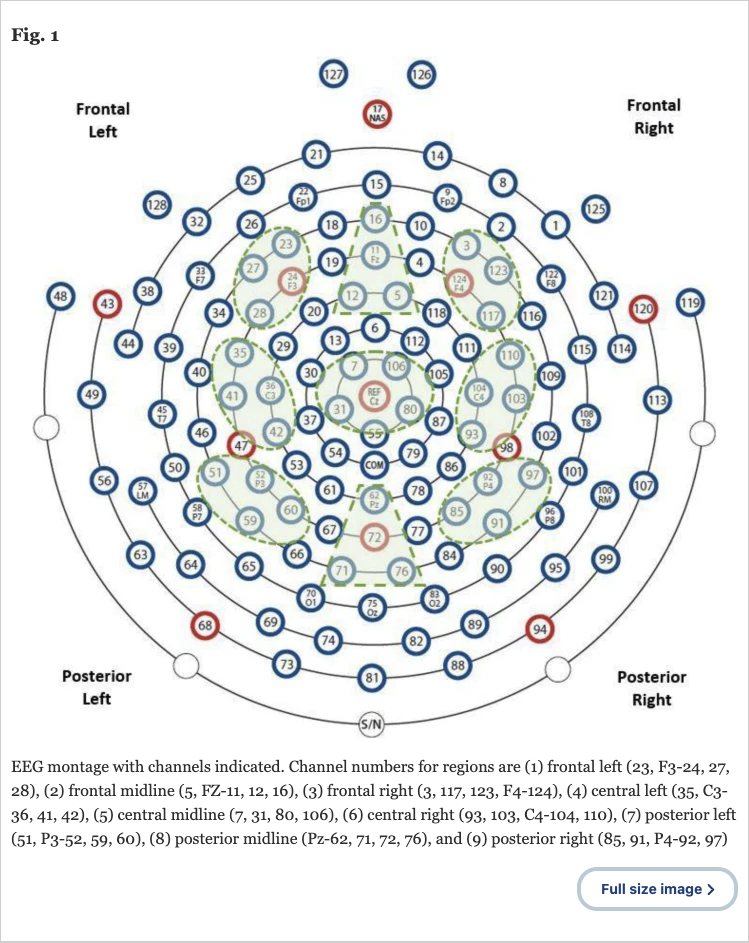

In [9]:
# Load infos about EEG montage and display regions channels

from IPython.display import Image, display

# Load and display an image
image_path = os.path.join(main, "EEG_regions_electrodes.png") # Update this to the path of your image file
display(Image(filename=image_path))


# Read channel dictonaries, defining for each area the number of the electrodes
channel_dict = {
        "frontal_left": [23, 24, 27, 28],
        "frontal_midline": [5, 11, 12, 16],
        "frontal_right": [3, 117, 123, 124],
        "central_left": [ 35, 36, 41, 42],
        "central_midline": [7, 31, 80, 106],
        "central_right": [93, 103, 104, 110],
        "posterior_left": [51, 52, 59, 60],
        "posterior_midline": [62, 71, 72, 76],
        "posterior_right": [85, 91, 92, 97]
                 }



In [10]:
# Compute descriptive statistics

asd_data = data[data['diagnosis']=="ASD"]
td_data = data[data['diagnosis']=="TD"]

for region in channel_dict.keys():

    # Get the name of each region
    region_column = f"{parameter}_{region}"
    
    asd_data_region = asd_data[region_column]
    td_data_region = td_data[region_column]

    # Print values
    print(f"Mean value for {region_column} in ASD is {asd_data[region_column].mean()}")
    print(f"Mean value for {region_column} in TD is {td_data[region_column].mean()}")
    print(f"Standard Deviation for {region_column} in ASD is {asd_data[region_column].std()}")
    print(f"Standard Deviation for {region_column} in TD is {td_data[region_column].std()}")

Mean value for alpha_amplitude_frontal_left in ASD is 0.9932060323627872
Mean value for alpha_amplitude_frontal_left in TD is 0.9598397921514802
Standard Deviation for alpha_amplitude_frontal_left in ASD is 0.41562580738586086
Standard Deviation for alpha_amplitude_frontal_left in TD is 0.41881404415673057
Mean value for alpha_amplitude_frontal_midline in ASD is 0.988240905980465
Mean value for alpha_amplitude_frontal_midline in TD is 0.9605108618796204
Standard Deviation for alpha_amplitude_frontal_midline in ASD is 0.42273928738167593
Standard Deviation for alpha_amplitude_frontal_midline in TD is 0.43998840221784136
Mean value for alpha_amplitude_frontal_right in ASD is 0.9863403780823246
Mean value for alpha_amplitude_frontal_right in TD is 0.9560569941484552
Standard Deviation for alpha_amplitude_frontal_right in ASD is 0.40813336003419376
Standard Deviation for alpha_amplitude_frontal_right in TD is 0.4289263064334175
Mean value for alpha_amplitude_central_left in ASD is 0.984082

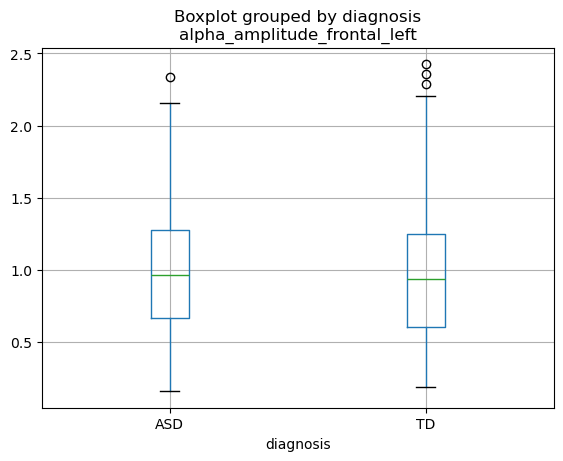

PearsonRResult(statistic=-0.129457391196531, pvalue=1.8162124619606462e-07)


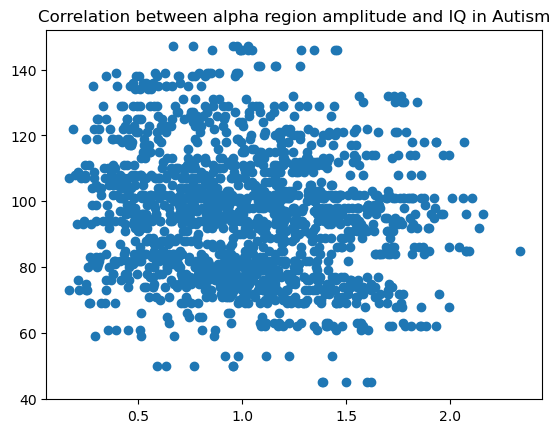

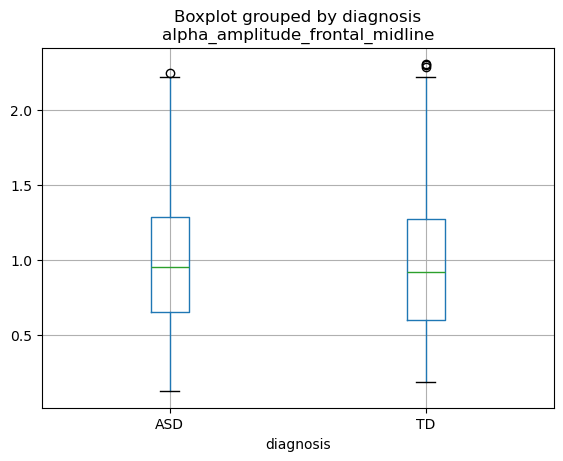

PearsonRResult(statistic=-0.13228859650799973, pvalue=9.263934523762378e-08)


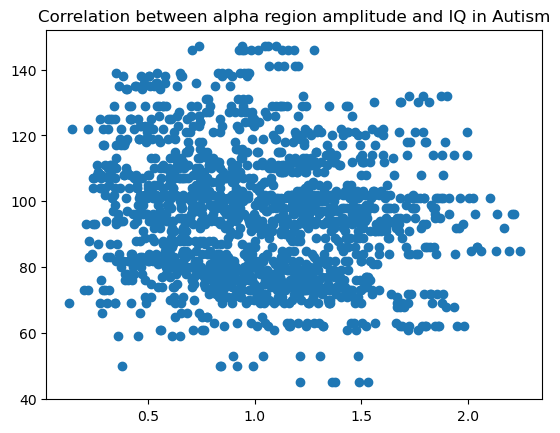

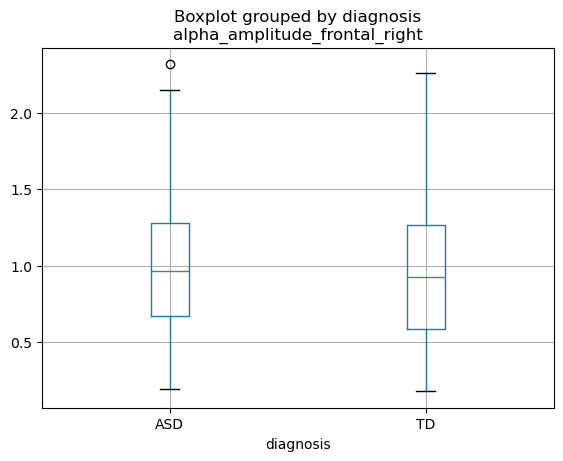

PearsonRResult(statistic=-0.11851026506996998, pvalue=1.7514626354236198e-06)


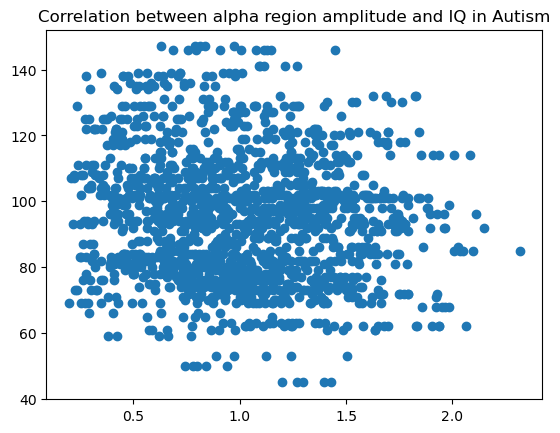

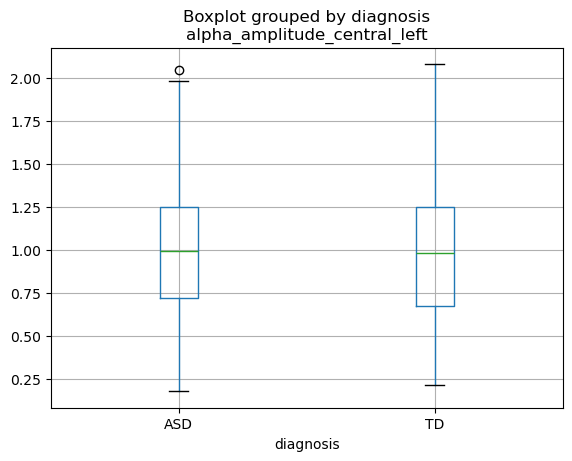

PearsonRResult(statistic=-0.12339350153261402, pvalue=5.913768149437665e-07)


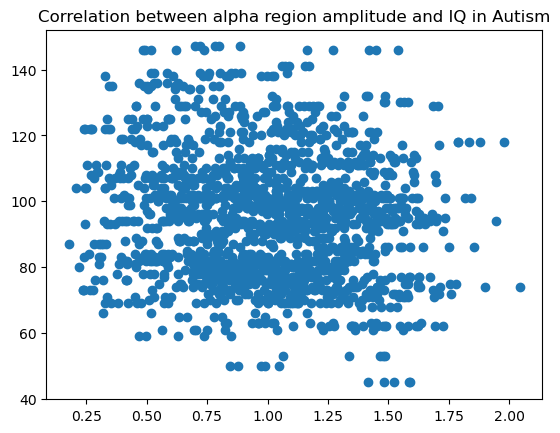

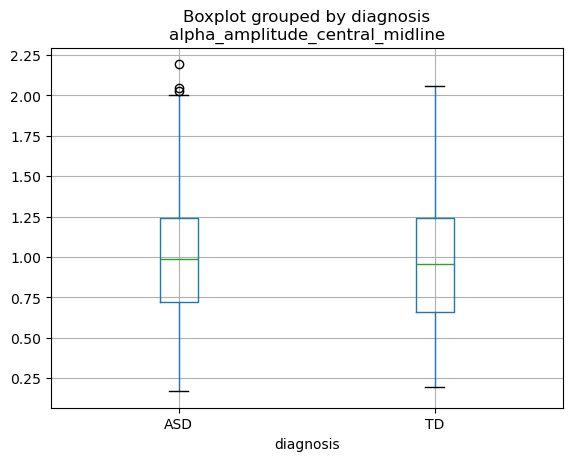

PearsonRResult(statistic=-0.11637939080262684, pvalue=2.482287392116083e-06)


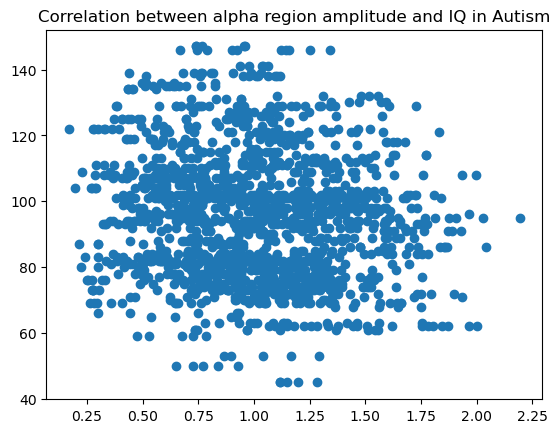

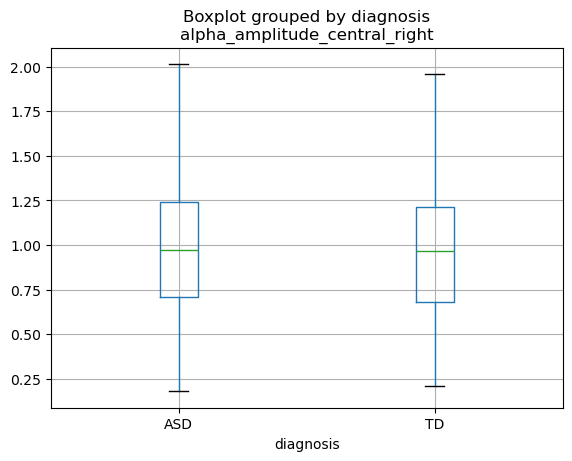

PearsonRResult(statistic=-0.10595068014025857, pvalue=1.8270215178937033e-05)


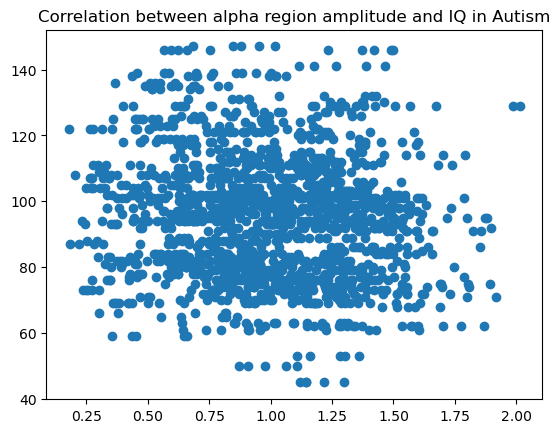

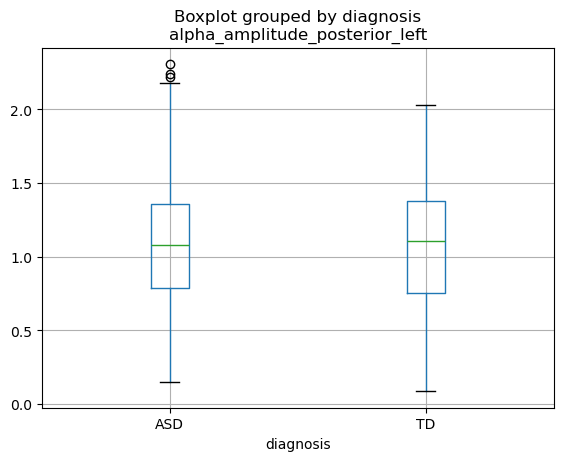

PearsonRResult(statistic=-0.09137360881642728, pvalue=0.0002198136194669484)


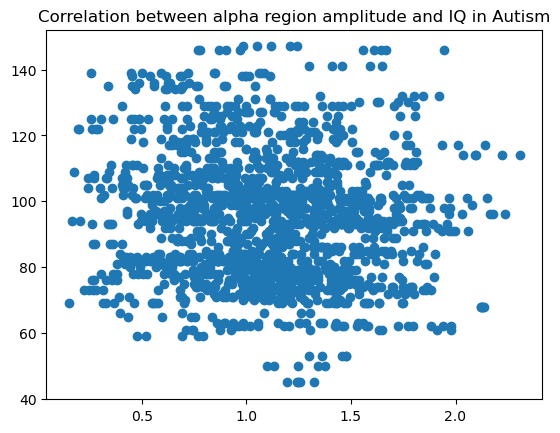

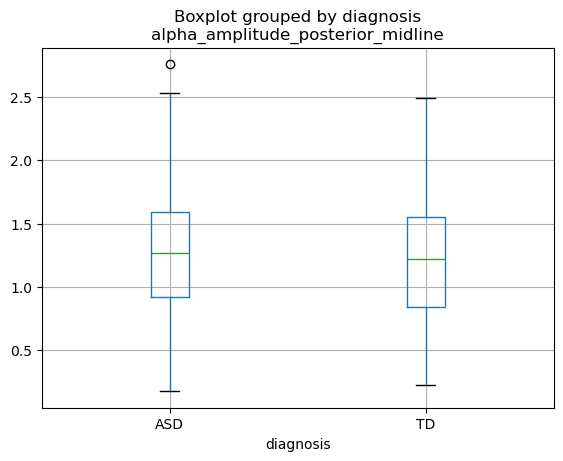

PearsonRResult(statistic=-0.09635700452245387, pvalue=0.00010059916789893987)


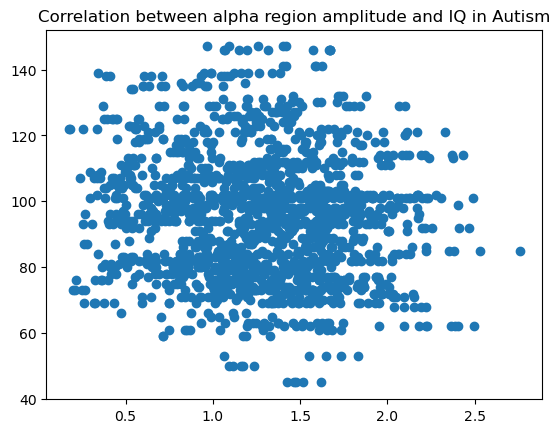

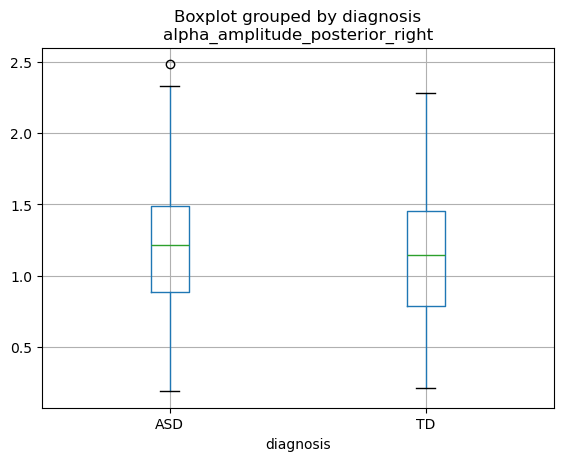

PearsonRResult(statistic=-0.09174885754593788, pvalue=0.00020792813225954792)


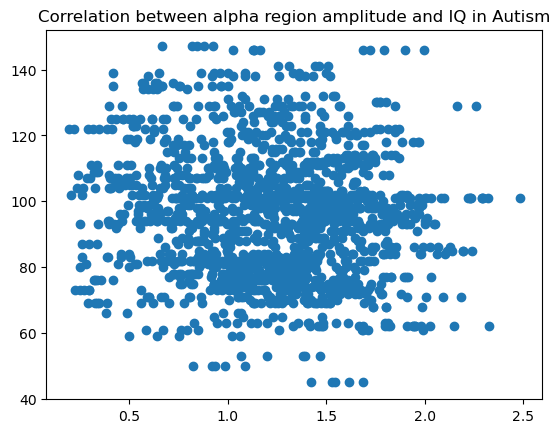

In [11]:
# For every region:
# 1) Plot case-control differences in the parameter
# 2) Compute for every region the correlation between parameter value and FIQ in ASD group.
#    This is done to explore the hypothesized association between alpha amplitude and cognitive development in Autism.

for region in channel_dict.keys():

    region_column = f"{parameter}_{region}"

    # Plot boxplot
    data.boxplot(column=region_column, by='diagnosis')
    plt.show()

    # Plot scatter 
    plt.scatter(asd_data[region_column], asd_data['fiq'])
    plt.title('Correlation between alpha region amplitude and IQ in Autism')

    # Remove NA
    asd_data_clean = asd_data.dropna(subset=[region_column, 'fiq'])

    # Compute pearson correlation
    r_pears = stats.pearsonr(asd_data_clean[region_column], asd_data_clean['fiq'])
    print(r_pears)



In [6]:
# For every region compute a mixed linear model with diagnosis and rs time point (1,2,3,4,5) as fixed effect and subject 
# as random effect
from statsmodels.formula.api import mixedlm

for region in channel_dict.keys():
  
    # Get region name
    region_column = f"{parameter}_{region}"
    filtered_data = data[data[region_column].notnull()] # Remove missing values

    # Generate formula and model
    model_formula = f"{region_column} ~ diagnosis * rs_block"
    model = mixedlm(model_formula, filtered_data, groups=filtered_data["subid"])

    # Fit the model
    result = model.fit()

    # Print the summary of the model
    print(region_column)
    print(result.summary())

alpha_amplitude_frontal_left
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: alpha_amplitude_frontal_left
No. Observations: 2881    Method:             REML                        
No. Groups:       584     Scale:              0.0275                      
Min. group size:  2       Log-Likelihood:     105.8040                    
Max. group size:  5       Converged:          Yes                         
Mean group size:  4.9                                                     
---------------------------------------------------------------------------
                            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    0.977     0.022  43.700  0.000   0.933   1.021
diagnosis[T.TD]             -0.002     0.036  -0.060  0.953  -0.073   0.068
rs_block                     0.003     0.003   1.249  0.211  -0.002   0.009
diagnosis

/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

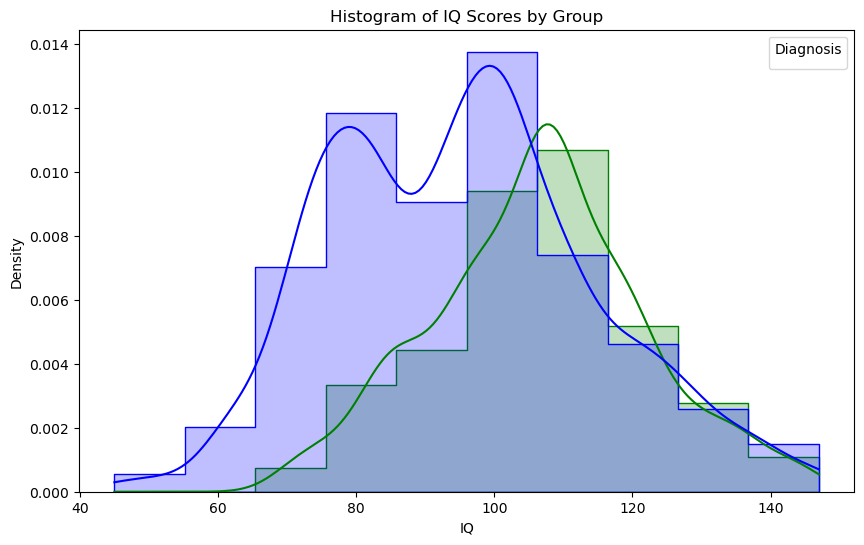

In [12]:
# Now, I want to explore full scale iq data distribution for the two groups.
# If ASD show a multiple-peak density distribution, I'm proceeding with subgrouping them based on IQ.

# Custom color palette
custom_palette = {'ASD': 'blue', 'TD': 'green'}

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data, x='fiq', hue='diagnosis', kde=True, bins=10, palette=custom_palette, element='step', stat='density')


# Adding labels and title
plt.xlabel('IQ')
plt.ylabel('Density')
plt.title('Histogram of IQ Scores by Group')
plt.legend(title='Diagnosis')

# Show the plot
plt.show()


/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.1

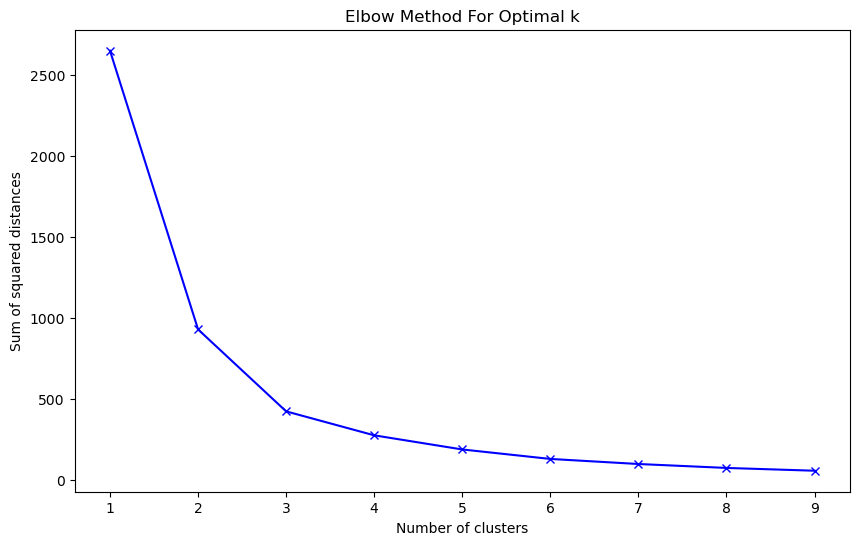

/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_50076/3592874237.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asd_data['Cluster'] = clusters
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(

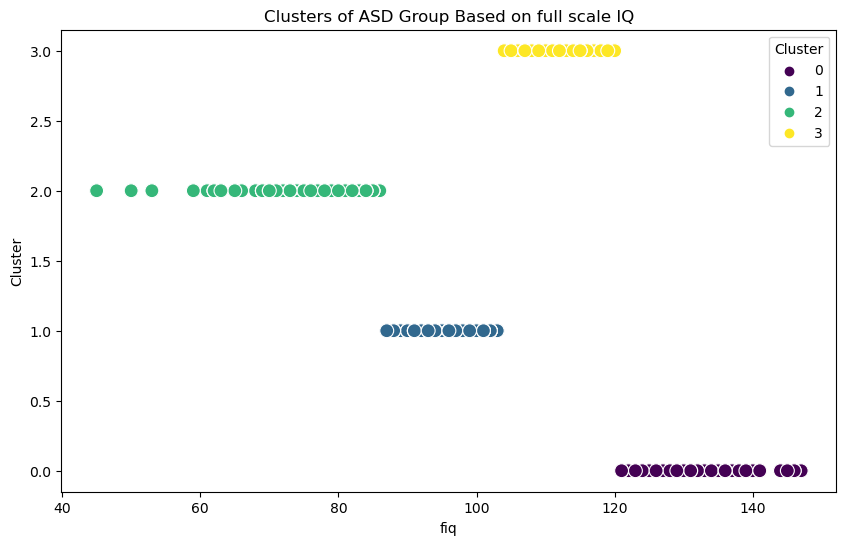

In [13]:
# ASD iq data show two peaks.
# Now, I'm perform k-means clustering (k-optimal = 2) to autism cluster subjects based on IQ

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Filter the data to include only the ASD group
asd_data = data[data['diagnosis'] == 'ASD']
asd_data = data[data['fiq'].notnull()] 


# Get all subjects IQ
fiq_scores = asd_data[['fiq']]

# Standardize the data
scaler = StandardScaler()
fiq_scores_scaled = scaler.fit_transform(fiq_scores)

# Determine the number of clusters using the elbow method
sum_of_squared_distances = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(fiq_scores_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# From the elbow plot, choose an appropriate number of clusters (e.g., 3)
optimal_k = 4

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(fiq_scores_scaled)

# Add the cluster labels to the original data
asd_data['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fiq', y='Cluster', data=asd_data, hue='Cluster', palette='viridis', s=100)
plt.xlabel('fiq')
plt.ylabel('Cluster')
plt.title('Clusters of ASD Group Based on full scale IQ')
plt.legend(title='Cluster')
plt.show()



/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inesseverino/anaconda3/envs/explore_cmifoof/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


0       1
3       3
6       2
7       2
8       2
       ..
2914    1
2915    1
2916    2
2917    0
2918    1
Name: Cluster, Length: 2649, dtype: int32

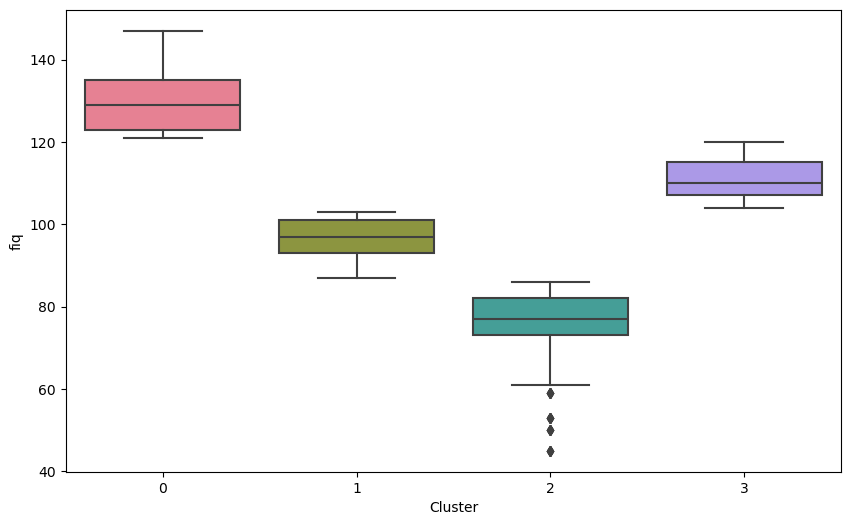

In [14]:
# Show clusters and their FIQ pattern

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='fiq', data=asd_data, palette='husl')

asd_data['Cluster']

In [15]:
# Give labels to clusters
asd_data['FIQ_subgroup'] = asd_data['Cluster'].map({0: 'HIGH', 1: 'LOW', 2: 'VERY_HIGH', 3:'VERY_LOW'})

# Add fake cluster label also to TD group
td_data['Cluster'] = 85 #arbitrary number to fill the column
td_data['FIQ_subgroup'] = "TD"

# Concatenate vertically ASD and TD dataframe (stack rows)
all_data_subgroups = pd.concat([asd_data, td_data], axis=0, ignore_index=True)


/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_50076/2325449167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asd_data['FIQ_subgroup'] = asd_data['Cluster'].map({0: 'HIGH', 1: 'LOW', 2: 'VERY_HIGH', 3:'VERY_LOW'})
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_50076/2325449167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_data['Cluster'] = 85 #arbitrary number to fill the column
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_50076/2325449167.py:6: SettingWi

In [16]:
# Initialize function to compute pairwise comparisons

from scipy import stats



def pairwise_comparisons(coefficients, std_errors, labels):
    num_groups = len(coefficients)
    comp_results = []
    for i in range(num_groups):
        for j in range(i + 1, num_groups):
            # Difference in coefficients
            effect_diff = coefficients[i] - coefficients[j]
            # Standard error of the difference
            se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)
            # Z-score
            z = effect_diff / se_diff
            # Two-tailed p-value
            p_value = 2 * (1 - stats.norm.cdf(np.abs(z)))
            comp_results.append((labels[i], labels[j], effect_diff, se_diff, z, p_value))
    return comp_results




In [110]:
# For every region compute a mixed linear model with FIQ subtype and rs time point (1,2,3,4,5) as fixed effect and subject 
# as random effect

for region in channel_dict.keys():

    
    region_column = f"{parameter}_{region}"
    filtered_data = all_data_subgroups[all_data_subgroups[region_column].notnull()]

    model_formula = f"{region_column} ~ FIQ_subgroup * rs_block"
    model = mixedlm(model_formula, filtered_data, groups=filtered_data["subid"])

    # Fit the model
    result = model.fit()

    # Print the summary of the model
    print(region_column)
    print(result.summary())

    #
    coefficients = result.fe_params[1:5]
    std_errors = result.bse_fe[1:5]

    labels = ['LOW', 'TD', 'VERY_HIGH', 'VERY_LOW']

    # Perform pairwise comparisons
    comparisons = pairwise_comparisons(coefficients, std_errors, labels)

    # Print results
    for comp in comparisons:
        print(f"Comparison: {comp[0]} vs {comp[1]}")
        print(f"  Effect Difference: {comp[2]:.3f}")
        print(f"  SE Difference: {comp[3]:.3f}")
        print(f"  Z-Score: {comp[4]:.3f}")
        print(f"  P-Value: {comp[5]:.3f}")
        print()

alpha_amplitude_frontal_left
                    Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  alpha_amplitude_frontal_left
No. Observations:  3708     Method:              REML                        
No. Groups:        555      Scale:               0.0586                      
Min. group size:   2        Log-Likelihood:      -708.0786                   
Max. group size:   10       Converged:           Yes                         
Mean group size:   6.7                                                       
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.913    0.028 32.703 0.000  0.858  0.968
FIQ_subgroup[T.LOW]                 0.164    0.036  4.631 0.000  0.095  0.234
FIQ_subgroup[T.TD]                 -0.253    0.031 -8.2

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_frontal_midline
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: alpha_amplitude_frontal_midline
No. Observations: 3707    Method:             REML                           
No. Groups:       555     Scale:              0.0583                         
Min. group size:  2       Log-Likelihood:     -722.9748                      
Max. group size:  10      Converged:          Yes                            
Mean group size:  6.7                                                        
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.915    0.028 32.396 0.000  0.859  0.970
FIQ_subgroup[T.LOW]                 0.180    0.036  5.062 0.000  0.111  0.250
FIQ_subgroup[T.TD]                 -0.274    0.031 -

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_frontal_right
                    Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: alpha_amplitude_frontal_right
No. Observations:   3689    Method:             REML                         
No. Groups:         555     Scale:              0.0560                       
Min. group size:    3       Log-Likelihood:     -640.4114                    
Max. group size:    10      Converged:          Yes                          
Mean group size:    6.6                                                      
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.931    0.028 33.785 0.000  0.877  0.985
FIQ_subgroup[T.LOW]                 0.136    0.035  3.880 0.000  0.067  0.204
FIQ_subgroup[T.TD]                 -0.280    0.030 -9.

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_central_left
                    Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  alpha_amplitude_central_left
No. Observations:  3722     Method:              REML                        
No. Groups:        555      Scale:               0.0522                      
Min. group size:   3        Log-Likelihood:      -457.6798                   
Max. group size:   10       Converged:           Yes                         
Mean group size:   6.7                                                       
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.916    0.026 35.604 0.000  0.866  0.967
FIQ_subgroup[T.LOW]                 0.150    0.033  4.532 0.000  0.085  0.215
FIQ_subgroup[T.TD]                 -0.123    0.029 -4.2

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_central_midline
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: alpha_amplitude_central_midline
No. Observations: 3726    Method:             REML                           
No. Groups:       555     Scale:              0.0478                         
Min. group size:  3       Log-Likelihood:     -329.8198                      
Max. group size:  10      Converged:          Yes                            
Mean group size:  6.7                                                        
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.901    0.025 35.796 0.000  0.851  0.950
FIQ_subgroup[T.LOW]                 0.179    0.032  5.589 0.000  0.116  0.242
FIQ_subgroup[T.TD]                 -0.202    0.028 -

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_central_right
                    Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: alpha_amplitude_central_right
No. Observations:   3726    Method:             REML                         
No. Groups:         555     Scale:              0.0515                       
Min. group size:    3       Log-Likelihood:     -424.6930                    
Max. group size:    10      Converged:          Yes                          
Mean group size:    6.7                                                      
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.916    0.025 35.963 0.000  0.866  0.966
FIQ_subgroup[T.LOW]                 0.143    0.033  4.332 0.000  0.078  0.207
FIQ_subgroup[T.TD]                 -0.120    0.029 -4.

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_posterior_left
                    Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: alpha_amplitude_posterior_left
No. Observations:  3724    Method:             REML                          
No. Groups:        555     Scale:              0.0570                        
Min. group size:   3       Log-Likelihood:     -670.2993                     
Max. group size:   10      Converged:          Yes                           
Mean group size:   6.7                                                       
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           1.032    0.028 37.309 0.000  0.978  1.086
FIQ_subgroup[T.LOW]                 0.165    0.035  4.694 0.000  0.096  0.233
FIQ_subgroup[T.TD]                 -0.251    0.030 -8

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_posterior_midline
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: alpha_amplitude_posterior_midline
No. Observations: 3723    Method:             REML                             
No. Groups:       555     Scale:              0.0660                           
Min. group size:  3       Log-Likelihood:     -984.1479                        
Max. group size:  10      Converged:          Yes                              
Mean group size:  6.7                                                          
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            1.140    0.031  37.326 0.000  1.080  1.200
FIQ_subgroup[T.LOW]                  0.172    0.038   4.516 0.000  0.097  0.247
FIQ_subgroup[T.TD]         

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)


alpha_amplitude_posterior_right
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: alpha_amplitude_posterior_right
No. Observations: 3738    Method:             REML                           
No. Groups:       555     Scale:              0.0591                         
Min. group size:  3       Log-Likelihood:     -757.9405                      
Max. group size:  10      Converged:          Yes                            
Mean group size:  6.7                                                        
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           1.085    0.028 38.064 0.000  1.029  1.141
FIQ_subgroup[T.LOW]                 0.163    0.036  4.549 0.000  0.093  0.233
FIQ_subgroup[T.TD]                 -0.297    0.031 -

/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_diff = coefficients[i] - coefficients[j]
/var/folders/c2/13fcv74s5yb2lw24_hcwv4jh0000gn/T/ipykernel_3068/3010389982.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  se_diff = np.sqrt(std_errors[i]**2 + std_errors[j]**2)
